In [1]:
import qiskit
import numpy as np, pandas as pd
%load_ext autoreload
%autoreload 2
import data, po, model, ast, csv

num_assets = 2

file_name = f'./result_{num_assets}.csv'
result = pd.read_csv(file_name)
for i in range(0, len(result)):
    asset_list = (result['assets'][i])
    array_string = asset_list.replace("[", "").replace("]", "").replace("'", "")
    asset_list = array_string.split()
    mu, sigma, _ = data.get_mu_sigma_specific('asset.csv', asset_list)
    numpy_result, qpo_result = (model.qpo(mu, sigma))
    
    file_name = f"compare_{num_assets}.csv"
    df = pd.read_csv(file_name)
    asset = df.assets.unique()
    row = [[str(asset_list),numpy_result, qpo_result]]
        
    if row[0][0] not in asset:
        with open(file_name, 'a') as csvfile:
            # Create a csv writer object
            # Check the value of first cell in row, if it is existing, then skip writing it
            
            csvwriter = csv.writer(csvfile)
            csvwriter.writerows(row)

/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:34: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(result.get(0, 0) - result.get(1, 0))*x_k*mu_k, abs(np.inner(x, mu))
/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:34: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(result.get(0, 0) - result.get(1, 0))*x_k*mu_k, abs(np.inner(x, mu))
/Users/vutuanhai/Documents/GitHub/quantum_finance/model.py:34: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(result.get(0, 0) - result.get(1, 0))*x_k*mu_k, abs(np.inner(x, mu))


{'0': 1926, '1': 8074}


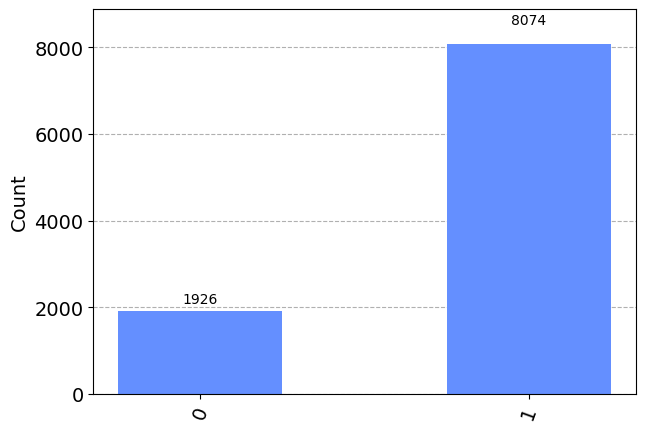

In [30]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram

# Create a quantum circuit with 1 qubit and 1 classical bit for measurement
qc = QuantumCircuit(1, 1)
qc.prepare_state([1/np.sqrt(5), 2/np.sqrt(5)])
# Step 2: Apply Y gate
qc.z(0)

# Step 3: Rotate for Y measurement (measure in the Y-basis)
# qc.sdg(0)  # Apply S† gate
#qc.h(0)  # Hadamard gate to rotate to the computational basis

# Step 4: Measure
qc.measure(0, 0)

# Execute the circuit on the qasm simulator
backend = Aer.get_backend('qasm_simulator')
result = execute(qc, backend, shots=10000).result()
counts = result.get_counts()

# Display the measurement results
print(counts)
plot_histogram(counts)


In [39]:
# create 8-dimensional binary vector
for i in [2,4,8,16,32,64]:
    x = np.random.randint(2, size=i)
    x = x /np.sqrt(np.sum(x))
    qc = qiskit.QuantumCircuit(int(np.log2(len(x))))
    qc.prepare_state(x)
    from qiskit.compiler import transpile
    from qiskit.providers.fake_provider import FakeQasmSimulator
    qc1 = transpile(qc, backend = FakeQasmSimulator())

    print(qc1.depth())

1
1
10
26
57
118


In [36]:



mu, sigma, _ = data.get_mu_sigma_specific('asset.csv', ['ATMUSDT','SOLUSDT','BNXUSDT', 'AAVEUSDT', 'APTUSDT'])
print(mu, sigma)

[-0.0029036236691319084, -0.0026702570589396614, -0.011380828801780924, 0.000619347729741717, -0.00527452174872208] [[0.00106326 0.00061676 0.00125094 0.00066726 0.00084313]
 [0.00061676 0.00145862 0.00140272 0.00107915 0.00136494]
 [0.00125094 0.00140272 0.00309352 0.00132747 0.00200171]
 [0.00066726 0.00107915 0.00132747 0.00203238 0.00127067]
 [0.00084313 0.00136494 0.00200171 0.00127067 0.00206379]]
